✅ Data loaded with shape: (38, 7)
                           file  num_clusters  silhouette  db_index  \
0  breast-cancer-clustering.csv             2    0.686691  0.521510   
1  breast-cancer-clustering.csv             2    0.692113  0.513853   
2  breast-cancer-clustering.csv             2    0.695235  0.508670   
3  breast-cancer-clustering.csv             2    0.691068  0.515361   
4  breast-cancer-clustering.csv             2    0.692113  0.513853   

      ch_index  num_agents  num_iterations  
0  1252.312404           5              50  
1  1278.570874           5             500  
2  1292.784821          10              50  
3  1273.503418          10             100  
4  1278.570874          25              50  

Datasets: ['breast-cancer-clustering.csv' 'glass-clustering.csv'
 'haberman-clustering.csv' 'iris-clustering.csv' 'wine-clustering.csv']

Hyperparameters: ['num_agents', 'num_iterations']

Summary statistics:
       num_clusters  silhouette   db_index     ch_index  nu

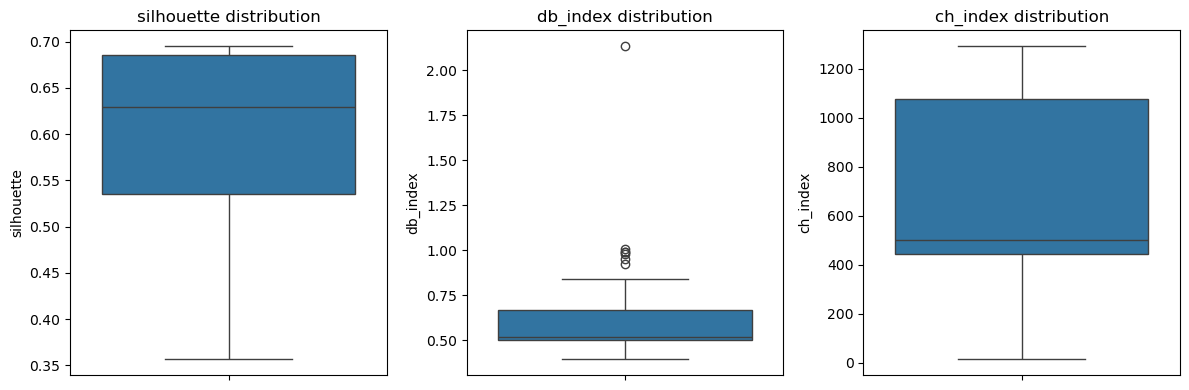

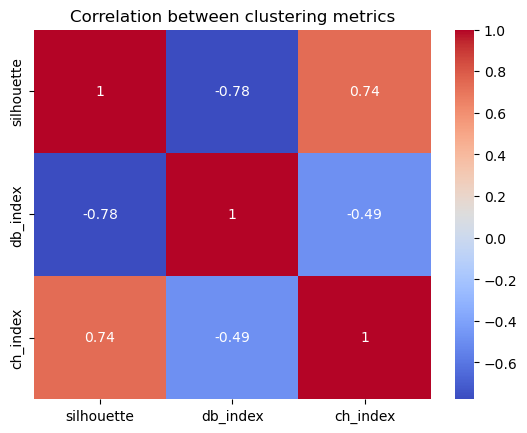

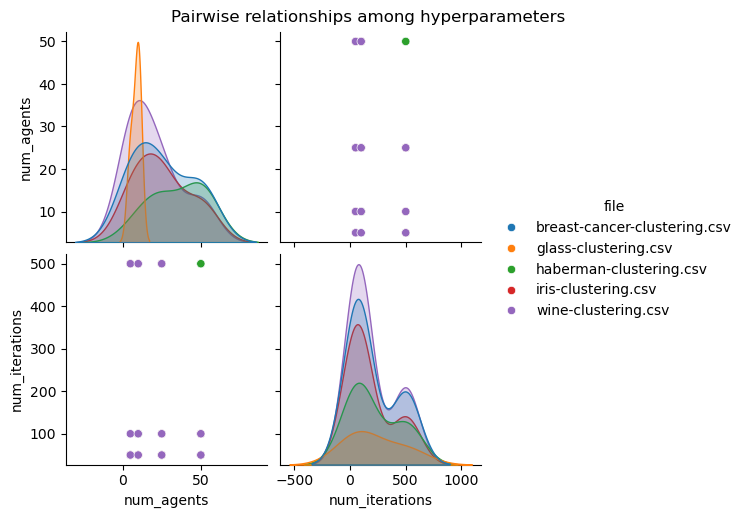

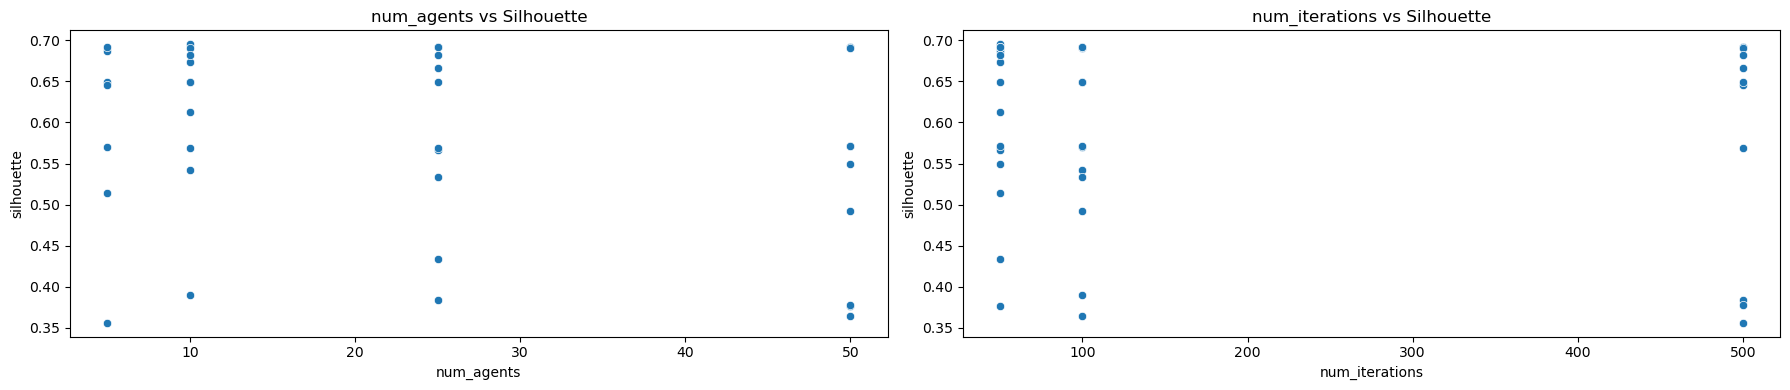

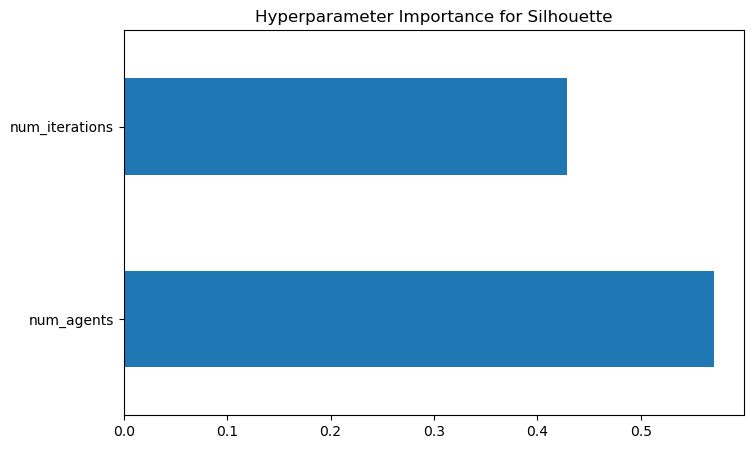

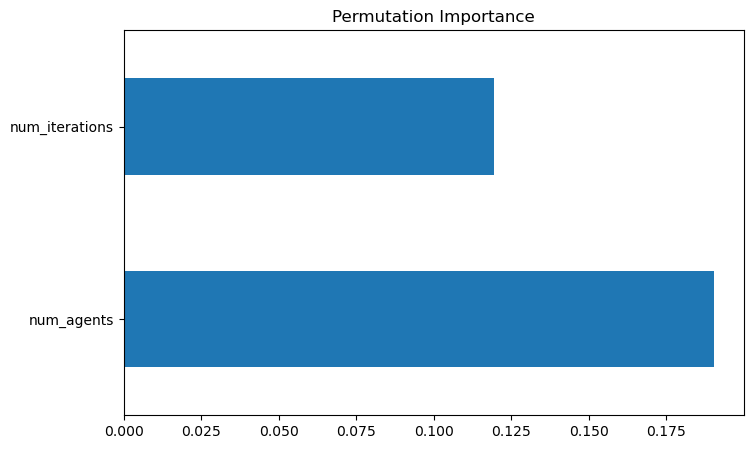


Top-performing parameter sets per dataset:
                           file  silhouette  db_index     ch_index  \
0  breast-cancer-clustering.csv    0.695235  0.508670  1292.784821   
1          glass-clustering.csv    0.613206  0.486313    36.093386   
2       haberman-clustering.csv    0.433244  0.981183    66.511475   
3           iris-clustering.csv    0.682131  0.392357   485.038116   
4           wine-clustering.csv    0.649365  0.496206   498.886164   

   num_agents  num_iterations  
0          10              50  
1          10              50  
2          25              50  
3          10             500  
4           5              50  


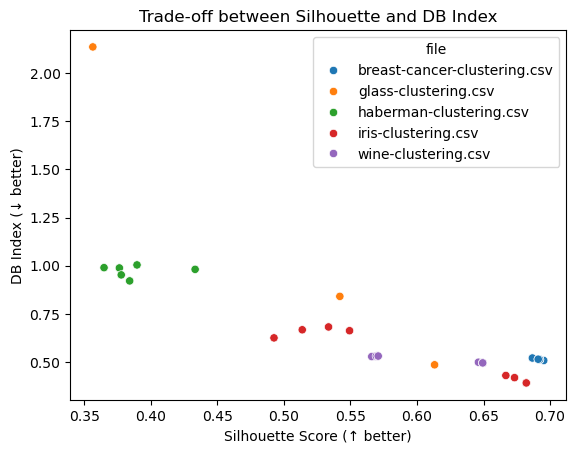

'\nKey conclusions to include in report:\n- Which parameters most influenced clustering quality.\n- Trends across datasets.\n- Trade-offs observed between silhouette, DB index, and CH index.\n- Recommended parameter ranges for stable performance.\n'

In [4]:
# ============================
# ANT CLUSTERING TUNING ANALYSIS PIPELINE
# ============================

import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

# === 1. Load data ===
df = pd.read_csv("")

# Parse 'params' JSON-like column into dicts
df["params"] = df["params"].apply(lambda x: ast.literal_eval(x))

# Expand hyperparameters into separate columns
params_df = pd.json_normalize(df["params"])
df = pd.concat([df.drop(columns=["params"]), params_df], axis=1)

print("✅ Data loaded with shape:", df.shape)
print(df.head())

# === 2. Basic overview ===
print("\nDatasets:", df["file"].unique())
print("\nHyperparameters:", list(params_df.columns))

# === 3. Summary statistics ===
summary = df.describe()
print("\nSummary statistics:")
print(summary)

# === 4. Visualize performance metrics ===
plt.figure(figsize=(12, 4))
for i, metric in enumerate(["silhouette", "db_index", "ch_index"], 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df[metric])
    plt.title(f"{metric} distribution")
plt.tight_layout()
plt.show()

# === 5. Correlations between metrics ===
corr = df[["silhouette", "db_index", "ch_index"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation between clustering metrics")
plt.show()

# === 6. Pairwise parameter relationships (vs silhouette) ===
num_params = params_df.shape[1]
sns.pairplot(df, vars=params_df.columns, 
             hue="file", diag_kind="kde")
plt.suptitle("Pairwise relationships among hyperparameters", y=1.02)
plt.show()

# === 7. Parameter impact on performance ===
fig, axes = plt.subplots(1, len(params_df.columns), figsize=(18, 4))
for ax, col in zip(axes, params_df.columns):
    sns.scatterplot(x=df[col], y=df["silhouette"], ax=ax)
    ax.set_title(f"{col} vs Silhouette")
plt.tight_layout()
plt.show()

# === 8. Feature importance (Random Forest) ===
# Prepare features
X = params_df.copy()
y = df["silhouette"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_scaled, y)

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
importances.plot(kind="barh", figsize=(8, 5), title="Hyperparameter Importance for Silhouette")
plt.show()

# === 9. Permutation importance (robust measure) ===
perm = permutation_importance(rf, X_scaled, y, n_repeats=10, random_state=42)
perm_imp = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)
perm_imp.plot(kind="barh", figsize=(8, 5), title="Permutation Importance")
plt.show()

# === 10. Best configurations per dataset ===
best_configs = (
    df.loc[df.groupby("file")["silhouette"].idxmax(), 
           ["file", "silhouette", "db_index", "ch_index"] + list(params_df.columns)]
    .reset_index(drop=True)
)
print("\nTop-performing parameter sets per dataset:")
print(best_configs)

# === 11. Trade-off visualization (Silhouette vs DB Index) ===
sns.scatterplot(x=df["silhouette"], y=df["db_index"], hue=df["file"])
plt.title("Trade-off between Silhouette and DB Index")
plt.xlabel("Silhouette Score (↑ better)")
plt.ylabel("DB Index (↓ better)")
plt.show()

# === 12. Optional: Save summary results ===
# best_configs.to_csv("best_ant_tuning_results.csv", index=False)
# print("💾 Saved best configurations to best_ant_tuning_results.csv")

# === 13. Conclusions (template for reporting) ===
"""
Key conclusions to include in report:
- Which parameters most influenced clustering quality.
- Trends across datasets.
- Trade-offs observed between silhouette, DB index, and CH index.
- Recommended parameter ranges for stable performance.
"""
